In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

plt.rcParams['font.sans-serif'] = ['SimHei']	# 显示中文
plt.rcParams['axes.unicode_minus'] = False		# 显示负号

## 1. 模拟实验

### 构造特征矩阵

In [3]:
# 定义矩阵规模
n = 100 # 样本量
p = 20 # 特征个数
p1 = 10 # 被选取的特征个数
sigma = 0.2 # 自变量的分布标准差
sigma_eps = 3 # 随机误差的标准差
M = 5000 # 重复次数

In [4]:
def design_matrix(mean: float = 0, std: float = sigma, n: int = 100, p: int = 20) -> np.ndarray:
    '''
    Construct a design matrix 
    All data are created from a normal distribution

    Parameters:
    mean - The expectation of the distribution
    std - The standard deviation of the distribution
    n - The number of samples
    p - The number of features

    Returns:
    X - The randomly-built matrix
    '''

    X = np.random.normal(mean, std, (n, p))
    # Add 1s at the first column
    X = sm.add_constant(X)
    
    return X

### 2. 构造响应变量

In [5]:
def get_beta(p: int = 20, p1: int = 10) -> np.ndarray:
    '''
    Create a beta with p1+1 1s and p-p1-1 0s

    Parameters:
    p - The number of features
    p1 - The number of chosen features

    Returns:
    beta - The created beta
    '''

    beta = np.zeros(p + 1)
    beta[: p1+1] = 1
    return beta

In [6]:
def get_epsilon(mean: float = 0, std: float = sigma_eps, n: int = 100) -> np.ndarray:
    '''
    Create a randomly-built epsilon vector

    Parameters:
    mean - The expectation of the distribution
    std - The standard deviation of the distribution
    n - The number of samples
    
    Returns:
    epsilon - The randomly-built epsilon vector
    '''

    return np.random.normal(mean, std, n)

### 3. 建立模型并预测

In [7]:
def GetY0ByK(X: np.ndarray, y: np.ndarray, x0: np.ndarray, k: int) -> float:
    '''
    Predict y0 by k features

    Parameters:
    X: The data for the training of the model
    y: The response variables for the training of the model
    x0: The point for prediction
    k: The number of chosen features

    Returns:
    y0_k - The prediction
    '''

    # Construct the model of k features
    model_k = LinearRegression()
    # Get the first k variables
    X_k = X[:, 1:k+1]
    # Get the beta_hat
    model_k.fit(X_k, y)
    intercept = model_k.intercept_
    coef = model_k.coef_

    # Make prediction
    y0_k = intercept + x0[1:k+1].T.dot(coef)

    return y0_k

In [8]:
bias = []
var = []
mse = []
#Construct the testing variables
x0 = 0.05 * np.ones(p + 1)
x0[0] = 1
for k in range(1, p+1):
    predictions = []
    for j in range(M):
        X = design_matrix(0, sigma, 100, 20)
        beta = get_beta(20, 10)
        epsilon = get_epsilon(0, sigma_eps, n)
        y = X.dot(beta) + epsilon # Response

        # Get the prediction of the best point
        # The best prediction
        y0 = x0.T.dot(beta)

        y0_k = GetY0ByK(X, y, x0, k)
        predictions.append(y0_k)
    predictions = np.array(predictions)
    predictions_mean = np.mean(predictions)

    full_result = x0.T.dot(beta)

    bias_k = (predictions_mean - full_result) ** 2
    bias.append(bias_k)

    var_k = np.var(predictions)
    var.append(var_k)

    mse_k = 1 / M * np.sum((predictions - full_result) ** 2)
    mse.append(mse_k)

print(bias)
print(var)
print(mse)

[0.19983919856626928, 0.16140720933305117, 0.1202836191028148, 0.08548130872324097, 0.057712468513363174, 0.03822945830466654, 0.024003248499733027, 0.011139928614829583, 0.0021041438990558755, 2.749465039514121e-06, 0.00010095340887235514, 1.6535628402189534e-05, 0.00016026898167572362, 8.20455274712849e-05, 5.812629128713788e-05, 9.311885830958492e-05, 8.192399913800646e-07, 0.0001570053791088732, 9.687237238942404e-05, 4.688411564926175e-05]
[0.10050646908143793, 0.10851633548349612, 0.11937497842145584, 0.12034628115369696, 0.12788275375234154, 0.13857700539866946, 0.14213777029681218, 0.15276461662945798, 0.1590468176944604, 0.16380622352933202, 0.17305975115483, 0.17946739074454382, 0.18879341350933376, 0.19722844871535614, 0.20315071373030652, 0.21270475758989205, 0.22806313986533397, 0.23800829693476544, 0.24429625574453384, 0.25685386312237785]
[0.30034566764770726, 0.2699235448165473, 0.2396585975242706, 0.20582758987693792, 0.18559522226570474, 0.1768064637033361, 0.16614101

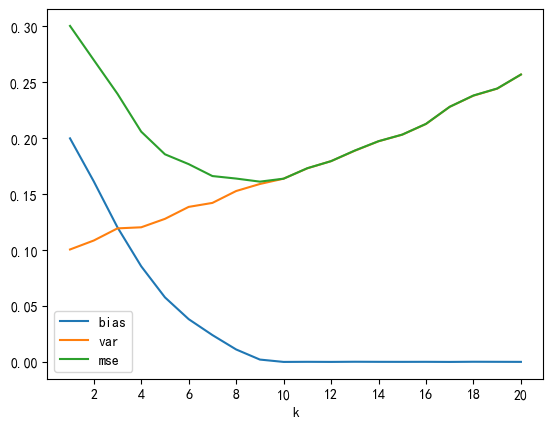

In [9]:
plt.plot(range(1, p+1), bias, label="bias")
plt.plot(range(1, p+1), var, label="var")
plt.plot(range(1, p+1), mse, label="mse")
plt.legend()
plt.xlabel("k")
plt.xticks([2 * i for i in range(1, 11)])
plt.show()

## 评述

从图中可以看出，MSE由Bias和Var两部分组成。

其中，Bias随k的增大而不断减小，Var随k的增大而不断增大。

在前期，Bias减小速率大于Var的增大速率，使得MSE呈现减小的趋势。

在后期，Bias的值逐渐趋近于0，减小速率变缓，小于Var的增大速率，使得MSE呈现增大的趋势。

在欠拟合的状态下：

模型方差较小，即模型较为稳定，但是代价是较低的模型准确度，因为在欠拟合的状态下模型预测偏差较大

在过拟合的状态下：

模型能够很好的拟合数据，得到的偏差较小。

但是此时模型的方差较大

即模型会随着其中的数据点的改变而出现巨大的变化，导致模型的稳定型较低，泛化能力较差。

In [17]:
import tensorflow as tf
import numpy as np
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten
import matplotlib.pyplot as plt


In [11]:

# 加载MNIST数据集
mnist = fetch_openml('mnist_784')
X = mnist.data.astype('float64')
y = mnist.target.astype('int64')
X /= 255.0

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.array(y_train, dtype=np.int64)
y_test = np.array(y_test, dtype=np.int64)

d:\anaconda\envs\tensorflow\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
def creat_model(hidden_dim, output_dim):
    model = Sequential([
        # Flatten(input_shape=[, input_dim]),
        Dense(hidden_dim, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])

    return model

In [12]:
def test(n_components):
    # 初始化RFF特征映射
    gamma = 1.0
    n_components = 1000
    rff = RBFSampler(gamma=gamma, n_components=n_components, random_state=42)
    X_train_rff = rff.fit_transform(X_train)
    X_test_rff = rff.transform(X_test)

    # 标准化RFF特征
    scaler = StandardScaler()
    X_train_rff = scaler.fit_transform(X_train_rff)
    X_test_rff = scaler.transform(X_test_rff)

    # 将数据转换为NumPy数组
    X_train_rff = np.array(X_train_rff, dtype=np.float32)
    X_test_rff = np.array(X_test_rff, dtype=np.float32)
    

    
    input_dim = n_components
    hidden_dim = 100
    output_dim = 10

    model = creat_model(hidden_dim, output_dim)

    # 定义损失函数和优化器
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # 编译模型
    model.compile(optimizer=optimizer, loss=loss_fn , metrics=['accuracy'])

    # 训练模型
    history = model.fit(X_train_rff, y_train, epochs=10, batch_size=32, verbose=1)

    pred = np.argmax(model.predict(X_test_rff), axis=1)
    print("OK")
    true_value = 0
    for i in range(pred.shape[0]):
        if pred[i] == y_test[i]:
            true_value += 1
    accuracy = true_value / pred.shape[0]
    
    return accuracy


In [19]:
n = [1000, 5000, 10000, 15000, 20000, 40000, 60000]
result = []

In [20]:
for i in n:
    accuracy = test(n)
    result.append(accuracy)

Epoch 1/10


d:\anaconda\envs\tensorflow\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1750/1750 [==============================] - 2s 1ms/step - loss: 2.4308 - accuracy: 0.1043
Epoch 2/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.2355 - accuracy: 0.1795
Epoch 3/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.1606 - accuracy: 0.2197
Epoch 4/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0381 - accuracy: 0.2777
Epoch 5/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.8838 - accuracy: 0.3433
Epoch 6/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.7358 - accuracy: 0.4000
Epoch 7/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.6117 - accuracy: 0.4470
Epoch 8/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.5134 - accuracy: 0.4839
Epoch 9/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4276 - accuracy: 0.5135
Epoch 10/10
438/438 [==============================] - 0s 674us/step
OK
Epoch 1/10


d:\anaconda\envs\tensorflow\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1750/1750 [==============================] - 3s 1ms/step - loss: 2.4284 - accuracy: 0.1045
Epoch 2/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.2352 - accuracy: 0.1793
Epoch 3/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.1613 - accuracy: 0.2189
Epoch 4/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0373 - accuracy: 0.2779
Epoch 5/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.8771 - accuracy: 0.3475
Epoch 6/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.7247 - accuracy: 0.4072
Epoch 7/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.5968 - accuracy: 0.4525
Epoch 8/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4947 - accuracy: 0.4891
Epoch 9/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4128 - accuracy: 0.5174
Epoch 10/10
438/438 [==============================] - 0s 660us/step
OK
Epoch 1/10


d:\anaconda\envs\tensorflow\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1750/1750 [==============================] - 2s 1ms/step - loss: 2.4334 - accuracy: 0.1055
Epoch 2/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.2351 - accuracy: 0.1771
Epoch 3/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.1610 - accuracy: 0.2178
Epoch 4/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0397 - accuracy: 0.2772
Epoch 5/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.8844 - accuracy: 0.3394
Epoch 6/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.7348 - accuracy: 0.3996
Epoch 7/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.6094 - accuracy: 0.4474
Epoch 8/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.5060 - accuracy: 0.4837
Epoch 9/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4243 - accuracy: 0.5115
Epoch 10/10
438/438 [==============================] - 0s 642us/step
OK
Epoch 1/10


d:\anaconda\envs\tensorflow\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1750/1750 [==============================] - 2s 1ms/step - loss: 2.4332 - accuracy: 0.1080
Epoch 2/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.2340 - accuracy: 0.1800
Epoch 3/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.1569 - accuracy: 0.2203
Epoch 4/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0319 - accuracy: 0.2809
Epoch 5/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.8747 - accuracy: 0.3479
Epoch 6/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.7228 - accuracy: 0.4052
Epoch 7/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.5962 - accuracy: 0.4556
Epoch 8/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4945 - accuracy: 0.4900
Epoch 9/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4099 - accuracy: 0.5181
Epoch 10/10
438/438 [==============================] - 0s 647us/step
OK
Epoch 1/10


d:\anaconda\envs\tensorflow\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1750/1750 [==============================] - 2s 1ms/step - loss: 2.4259 - accuracy: 0.1067
Epoch 2/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.2347 - accuracy: 0.1774
Epoch 3/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.1621 - accuracy: 0.2199
Epoch 4/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0391 - accuracy: 0.2775
Epoch 5/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.8875 - accuracy: 0.3411
Epoch 6/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.7378 - accuracy: 0.3966
Epoch 7/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.6118 - accuracy: 0.4463
Epoch 8/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.5118 - accuracy: 0.4834
Epoch 9/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4284 - accuracy: 0.5113
Epoch 10/10
438/438 [==============================] - 0s 636us/step
OK
Epoch 1/10


d:\anaconda\envs\tensorflow\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1750/1750 [==============================] - 2s 1ms/step - loss: 2.4314 - accuracy: 0.1049
Epoch 2/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.2318 - accuracy: 0.1812
Epoch 3/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.1562 - accuracy: 0.2212
Epoch 4/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0325 - accuracy: 0.2807
Epoch 5/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.8739 - accuracy: 0.3464
Epoch 6/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.7262 - accuracy: 0.4060
Epoch 7/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.6002 - accuracy: 0.4506
Epoch 8/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.5004 - accuracy: 0.4845
Epoch 9/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4164 - accuracy: 0.5168
Epoch 10/10
438/438 [==============================] - 0s 616us/step
OK
Epoch 1/10


d:\anaconda\envs\tensorflow\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1750/1750 [==============================] - 2s 1ms/step - loss: 2.4347 - accuracy: 0.1079
Epoch 2/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.2303 - accuracy: 0.1811
Epoch 3/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.1552 - accuracy: 0.2227
Epoch 4/10
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0295 - accuracy: 0.2836
Epoch 5/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.8736 - accuracy: 0.3461
Epoch 6/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.7203 - accuracy: 0.4085
Epoch 7/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.5961 - accuracy: 0.4557
Epoch 8/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4931 - accuracy: 0.4895
Epoch 9/10
1750/1750 [==============================] - 2s 1ms/step - loss: 1.4104 - accuracy: 0.5192
Epoch 10/10
438/438 [==============================] - 0s 613us/step
OK


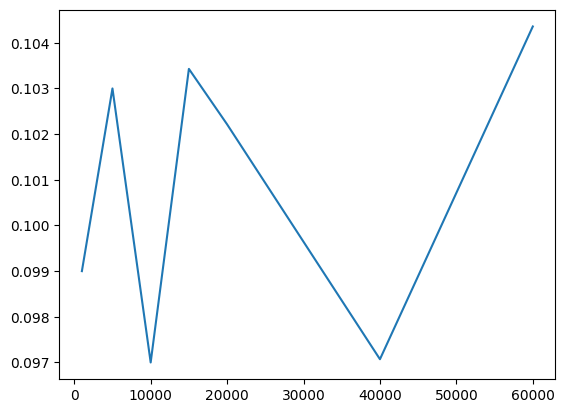

In [21]:
plt.plot(n, result)
plt.show()